In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import re
import matplotlib.pyplot as plt 
from sklearn.utils import resample
from sklearn.metrics import recall_score,f1_score,precision_score,confusion_matrix,accuracy_score,roc_auc_score,RocCurveDisplay,ConfusionMatrixDisplay
import string 
import seaborn as sb
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings("ignore")
import unidecode
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 

from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
import plotly.express as px
from collections import Counter
%matplotlib inline

In [2]:
random_state = 42 

# Reading the dataset

In [3]:
df = pd.read_csv("tweets.csv", index_col=0)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


# Data exploration

Data is collected from Kaggle and merged from various datasets containing hate and non-hate speech tweets.
Is my dataset balanced?

<Axes: >

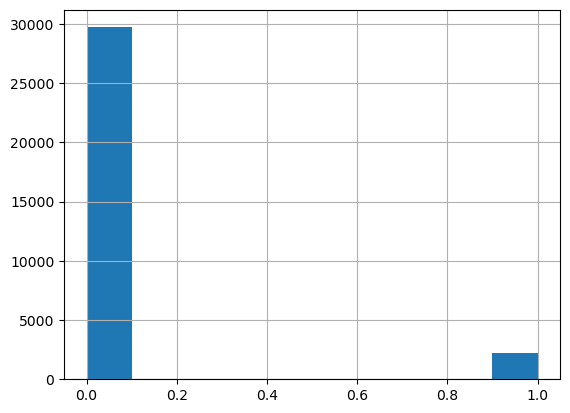

In [4]:
df.label.hist()

In [5]:
print(f'{len(df[df["label"]==0])/len(df)} of tweets are no-hate')
print(len(df),' tweets total,',len(df[df["label"]==0]),"non hate", len(df[df["label"]==1]), "hate")

0.9298542018647143 of tweets are no-hate
31962  tweets total, 29720 non hate 2242 hate


#### WordCloud

In [6]:
text_pos = " ".join(df['tweet'][df['label'] == 0])
text_neg = " ".join(df['tweet'][df['label'] == 1])

In [7]:
def plot_word_cloud(text_pos,text_neg):
    fig, axs = plt.subplots(1,2 , figsize=(16,8))
    cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
    cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
    axs[0].imshow(cloud_pos, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('Non-Hate Comments')
    axs[1].imshow(cloud_neg, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Hate Comments')

    plt.show()

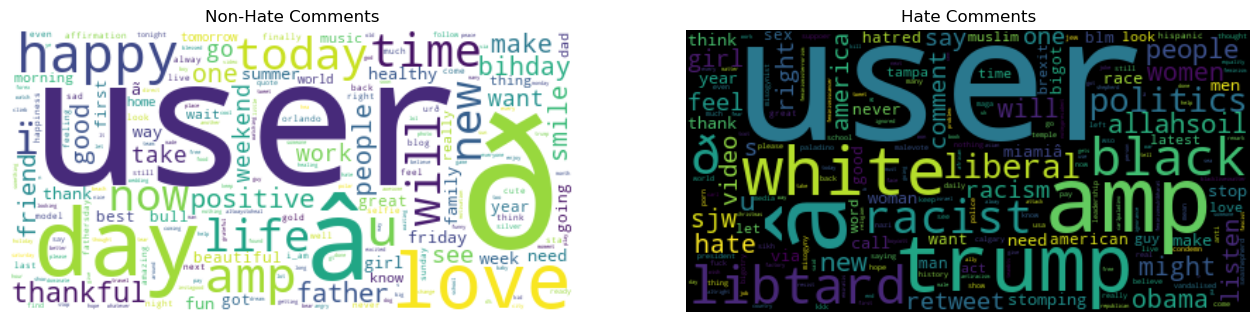

In [8]:
plot_word_cloud(text_pos,text_neg)

#### Word Bar Chart

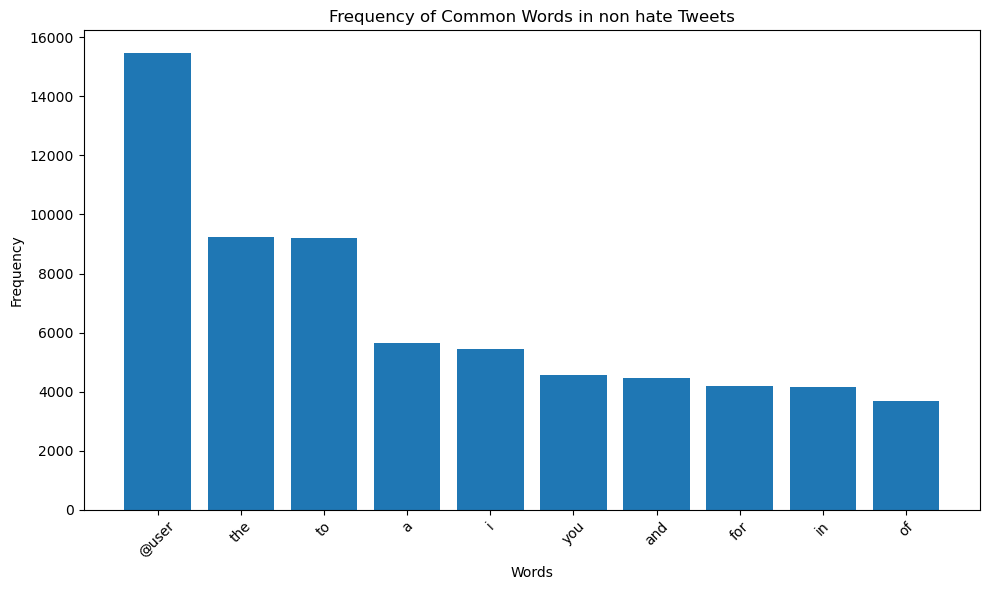

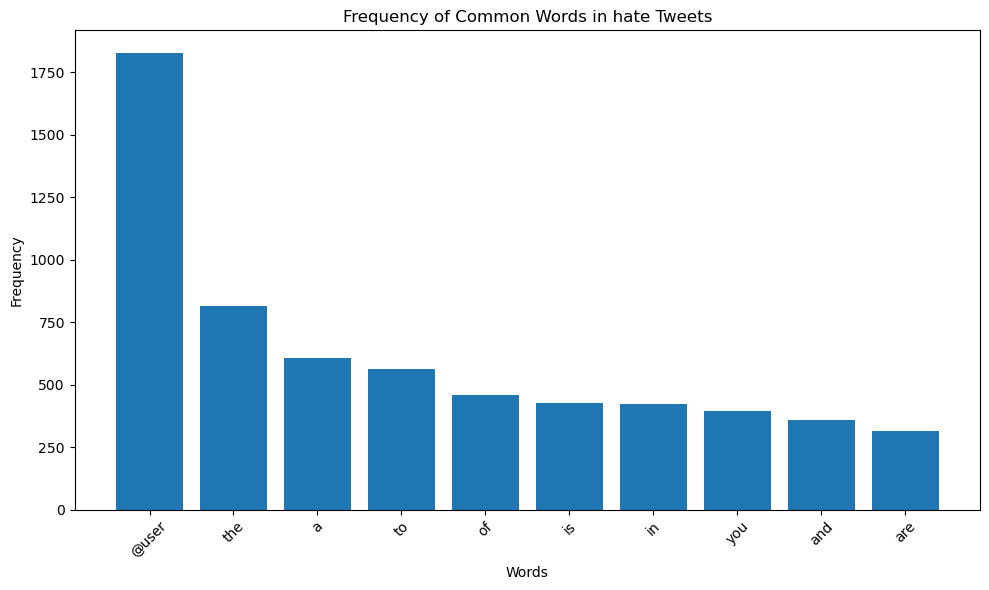

In [9]:
def create_bar_chart(words, counts, title): 
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Count the frequency of each word
word_counts_pos = Counter(text_pos.split())

word_counts_neg = Counter(text_neg.split())

# Extract the most common words and their frequencies
top_words_pos = [word for word, count in word_counts_pos.most_common(10)]
top_counts_pos = [count for word, count in word_counts_pos.most_common(10)]

top_words_neg = [word for word, count in word_counts_neg.most_common(10)]
top_counts_neg = [count for word, count in word_counts_neg.most_common(10)]

# Create the bar chart
create_bar_chart(top_words_pos, top_counts_pos, 'Frequency of Common Words in non hate Tweets')
create_bar_chart(top_words_neg, top_counts_neg, 'Frequency of Common Words in hate Tweets')

## TextCleanerTransformer

#### What it does: 
    -Remove mentions, non-alphanumeric characters, URLs, and retweets.
    -Remove punctuation.
    -Convert any non-ASCII characters to their closest ASCII equivalent.
    -Remove stopwords.
    -Remove any variants of "hmm".
    -Perform lemmatization to reduce words to their base form, preserving linguistic meaning.

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean(text):
        text = text.lower()
        text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
        text = ''.join([char for char in text if char not in string.punctuation])
        text =' '.join([unidecode.unidecode(word) for word in text.split()])
        text = ' '.join([word for word in text.split() if not word in stop_words])
        text = re.sub(r'h(m)+', '', text)  # correct way to remove 'hmm' and variants
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # choose lemmatization over stemming
        return text
    
class TextCleanerTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_cleaned = X.apply(clean)
        return X_cleaned


# Most common words (after cleaning the tweets)

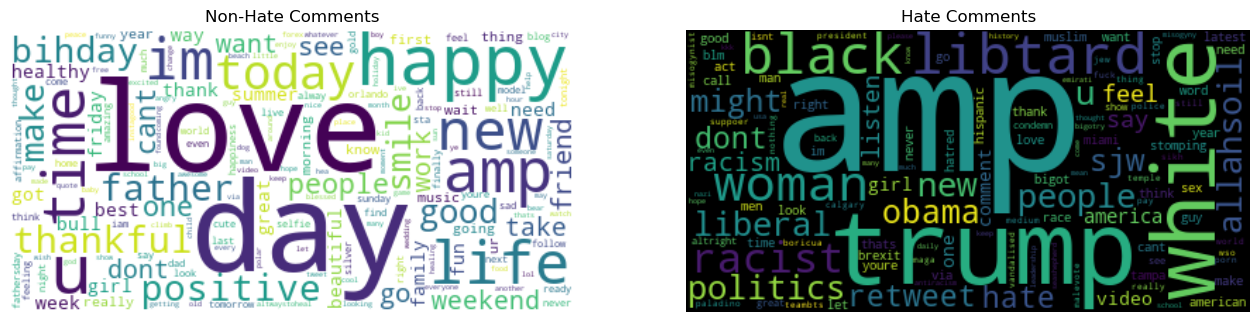

In [11]:
cleaned = df['tweet'].apply(clean)
text_pos = " ".join(df[df['label'] == 0]['tweet'].apply(clean))
text_neg = " ".join(df[df['label'] == 1]['tweet'].apply(clean))

plot_word_cloud(text_pos,text_neg)

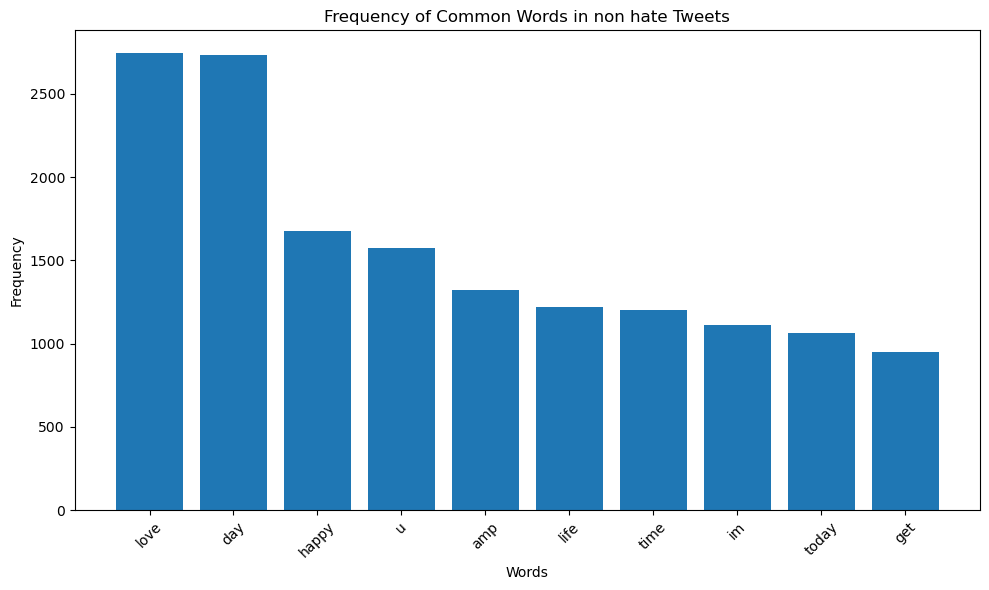

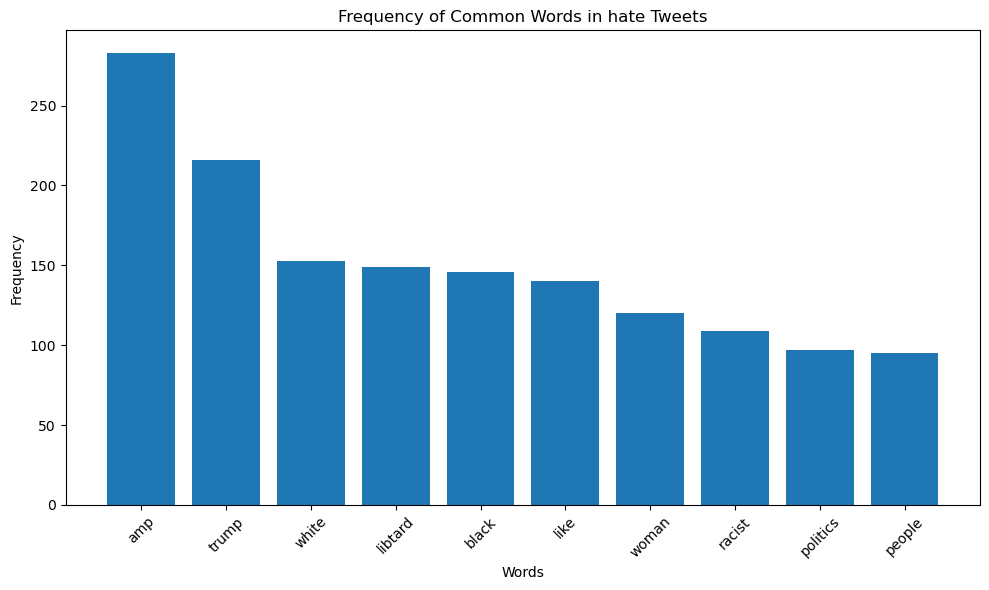

In [12]:
word_counts_pos = Counter(text_pos.split())
word_counts_neg = Counter(text_neg.split())

# Extract the most common words and their frequencies
top_words_pos = [word for word, count in word_counts_pos.most_common(10)]
top_counts_pos = [count for word, count in word_counts_pos.most_common(10)]

top_words_neg = [word for word, count in word_counts_neg.most_common(10)]
top_counts_neg = [count for word, count in word_counts_neg.most_common(10)]

# Create the bar chart
create_bar_chart(top_words_pos, top_counts_pos, 'Frequency of Common Words in non hate Tweets')
create_bar_chart(top_words_neg, top_counts_neg, 'Frequency of Common Words in hate Tweets')

### fit_predict_eval() function
The fit_predict_eval function performs Stratified K-fold cross-validation on a binary text classification model.

It takes as input a DataFrame and a pipeline, trains the model, makes predictions, evaluates using metrics such as accuracy, precision, recall, F1 score, and ROC AUC, and displays a confusion matrix and ROC curve for each fold.

The function returns the average scores of all metrics, providing a comprehensive overview of the model's performance.

In [13]:
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from scipy import interp

def fit_predict_eval(df, pipeline, n_splits=5, label_int=False):
    X = df['tweet']
    y = df['label'].astype('str')
    
    skf = StratifiedKFold(n_splits=n_splits)
    scores = {
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1": [],
        "roc_auc": []
    }
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)

        # Compute ROC curve and area under the curve for this fold
        fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1], pos_label='1')
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        scores["accuracy"].append(accuracy_score(y_test, predictions))
        scores["recall"].append(recall_score(y_test, predictions, pos_label="1"))
        scores["precision"].append(precision_score(y_test, predictions, pos_label="1"))
        scores["f1"].append(f1_score(y_test, predictions, pos_label="1"))
        scores["roc_auc"].append(roc_auc_score(y_test, predictions))

    # Plot ROC curve
    plt.figure()
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f)' % mean_auc, lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    cm = confusion_matrix(y_test, predictions, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot()
    plt.show()

    # average the scores
    for key in scores:
        scores[key] = np.mean(scores[key])
    
    return scores


scores = {
    
}

## Logistic regression without downsampling

Evaluation for 4000 max_features in Tfidf


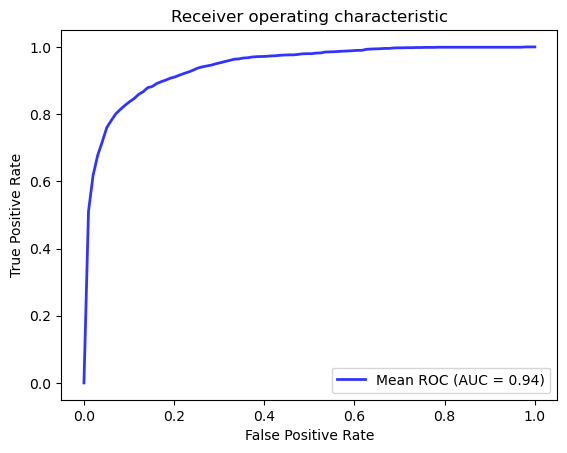

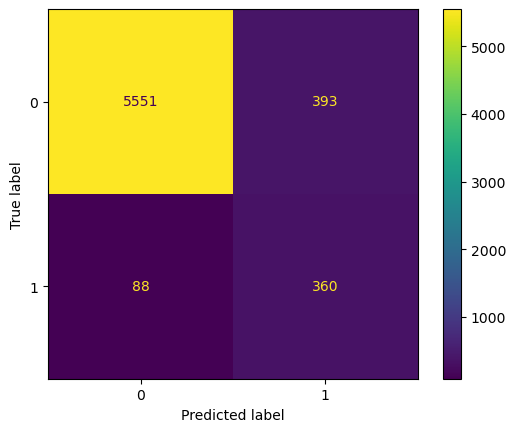

{'accuracy': 0.9199048767944131, 'recall': 0.7961680719058226, 'precision': 0.4600605449265635, 'f1': 0.5826653400884713, 'roc_auc': 0.862703820609708}
Evaluation for 6000 max_features in Tfidf


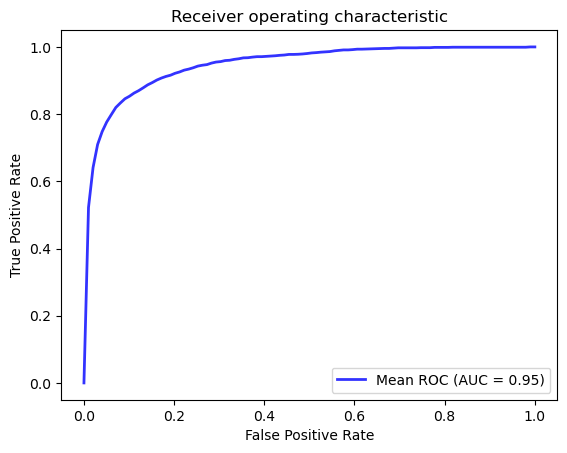

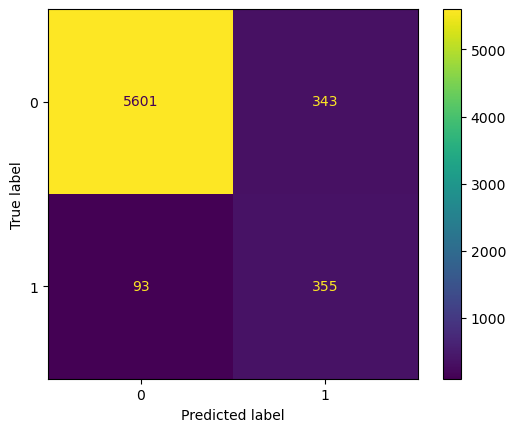

{'accuracy': 0.9295100222063126, 'recall': 0.7948297804645243, 'precision': 0.4988679406256738, 'f1': 0.6127299824463938, 'roc_auc': 0.8672500180922892}
Evaluation for 7000 max_features in Tfidf


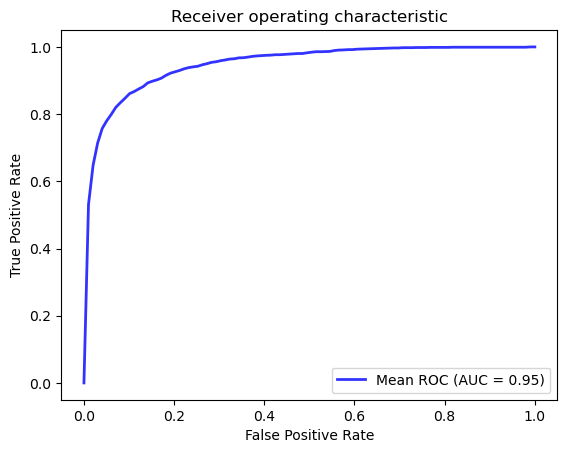

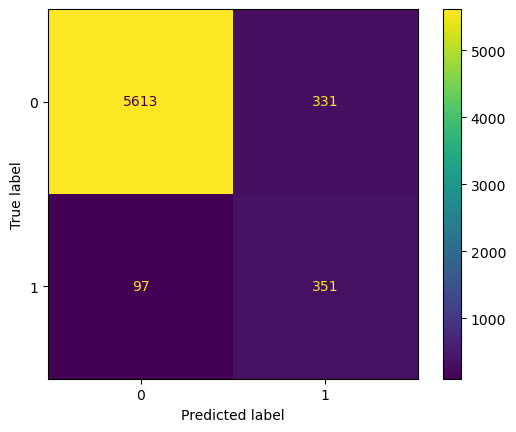

{'accuracy': 0.9318565734150326, 'recall': 0.792598631880369, 'precision': 0.5096149954827129, 'f1': 0.6200898834794742, 'roc_auc': 0.8674803388203998}
Evaluation for 9000 max_features in Tfidf


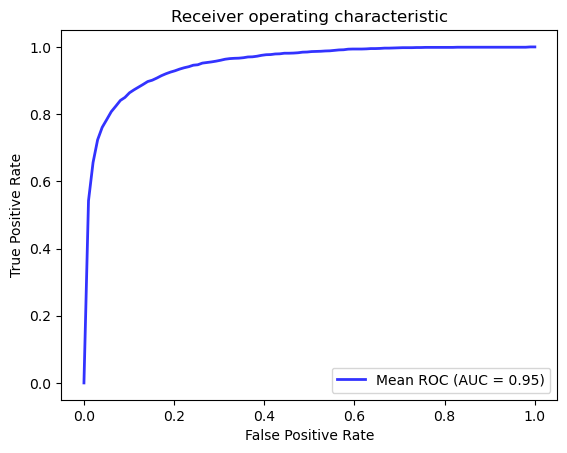

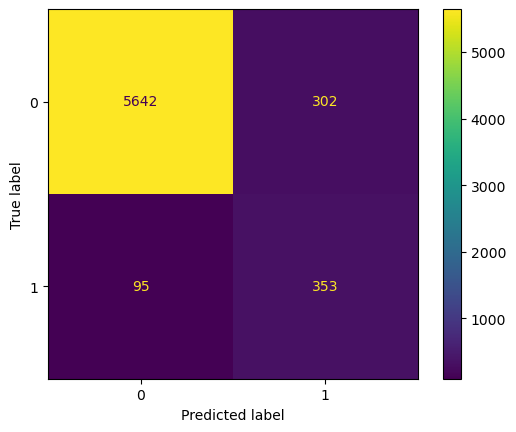

{'accuracy': 0.935204332139717, 'recall': 0.7925996261533566, 'precision': 0.5255923079278328, 'f1': 0.63185939488532, 'roc_auc': 0.8692809705463957}
Evaluation for 10000 max_features in Tfidf


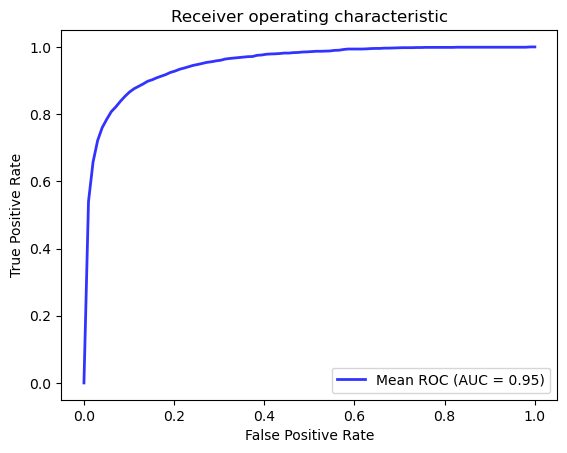

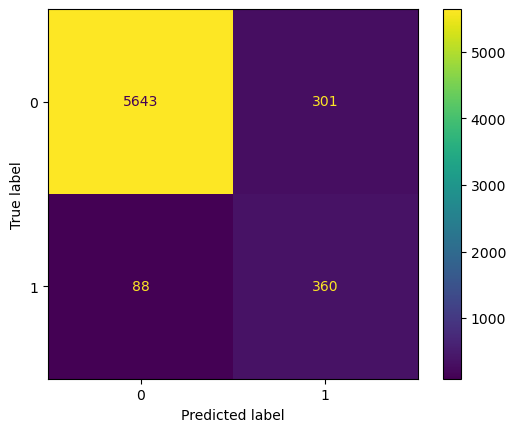

{'accuracy': 0.9357675312504465, 'recall': 0.7934954661151765, 'precision': 0.5283890555741666, 'f1': 0.6341553575599838, 'roc_auc': 0.8699980695313434}


In [14]:
# Create the pipeline for different values of max_features to see, what value is optimal

for mf in [4000,6000,7000,9000,10000]:
    logistic_pipeline = Pipeline([
        ('text_cleaning', TextCleanerTransformer()),
        ('tfidf', TfidfVectorizer(max_features=mf)),
        ('classifier', LogisticRegression(class_weight="balanced",random_state = random_state))
    ])
    
    print(f"Evaluation for {mf} max_features in Tfidf")
    log_reg = fit_predict_eval(df,logistic_pipeline)
    print(log_reg)
scores[f"log_reg_no_downsampling"] = log_reg


#### Because, I did not use any down/up -sampling technique, the very is extremely low precision

#### Let's try down-sampling:

array([[<Axes: title={'center': 'label'}>]], dtype=object)

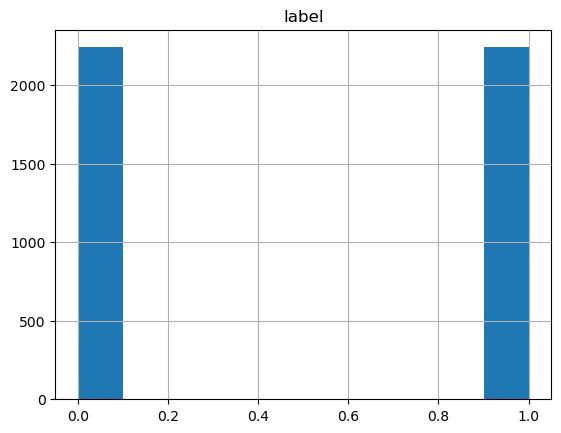

In [15]:
# Separate majority and minority classes
df_majority = df[df.label==0]
df_minority = df[df.label==1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(len(df_minority), replace=False)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the new dataset
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)

# Now your new dataframe df_downsampled has balanced classes.
df_downsampled.hist()

### Logistic regression after downsampling

Eval for 4000 max_features in tfidf


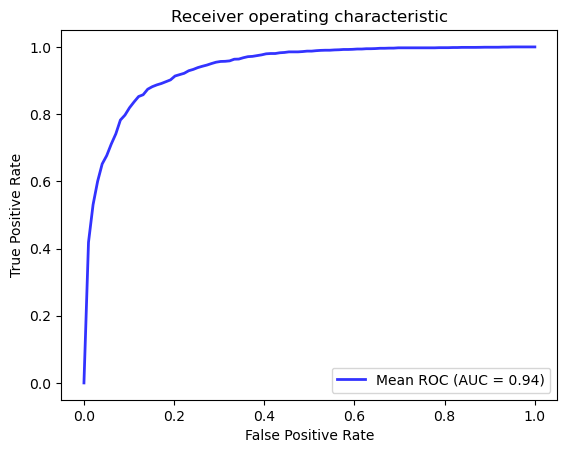

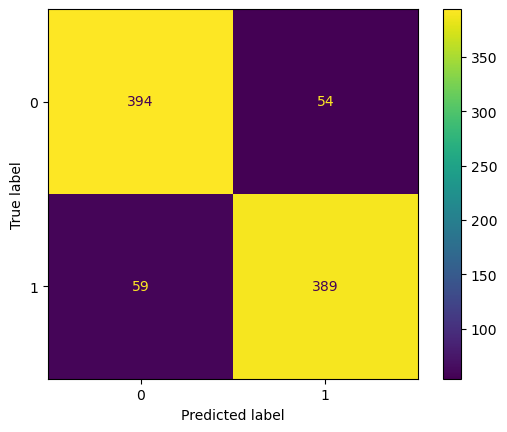

{'accuracy': 0.8670844780219781, 'recall': 0.8599477012408526, 'precision': 0.8724172372817133, 'f1': 0.8660840220383736, 'roc_auc': 0.867088072701241}
Eval for 5500 max_features in tfidf


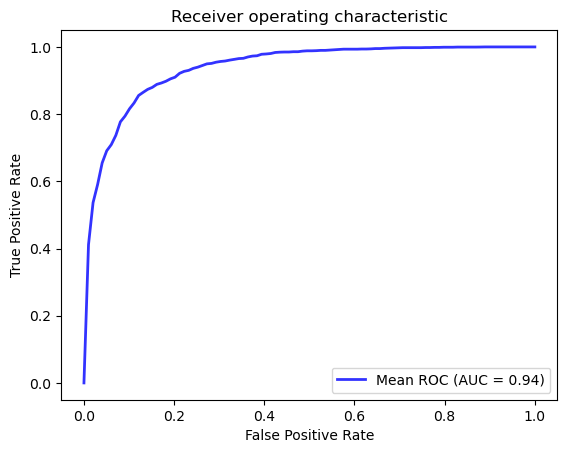

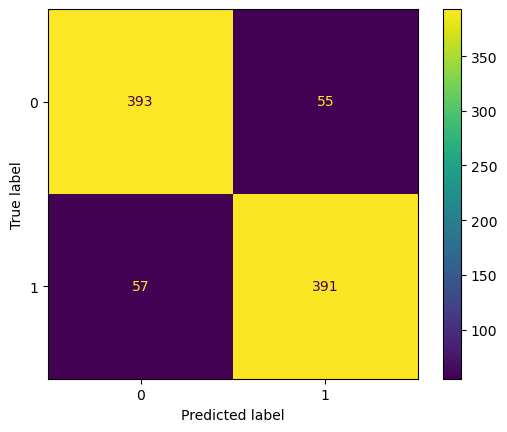

{'accuracy': 0.8666387959866221, 'recall': 0.8599467069678651, 'precision': 0.8715629957779129, 'f1': 0.8656950228084641, 'roc_auc': 0.8666401527203309}
Eval for 7000 max_features in tfidf


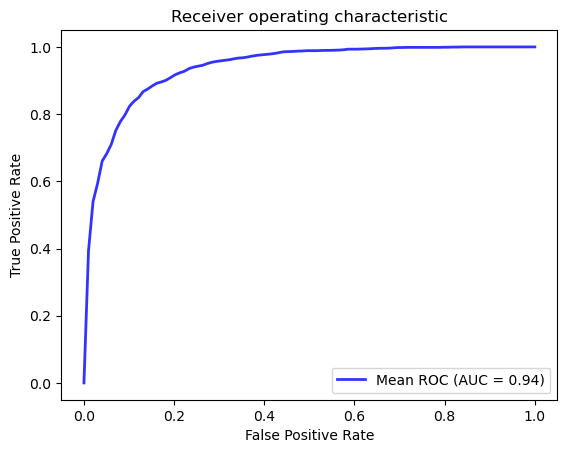

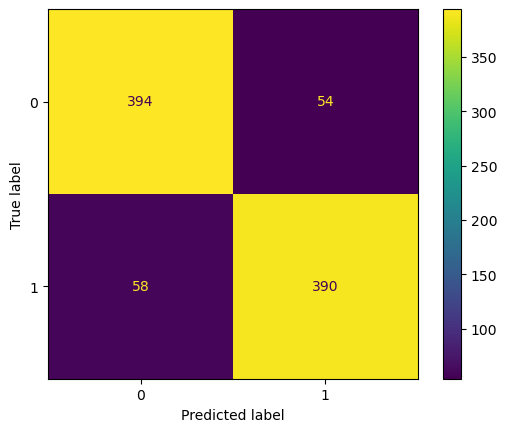

{'accuracy': 0.865746934225195, 'recall': 0.8586074212535794, 'precision': 0.8709784285829721, 'f1': 0.8647240821314398, 'roc_auc': 0.8657477927139675}
Eval for 9000 max_features in tfidf


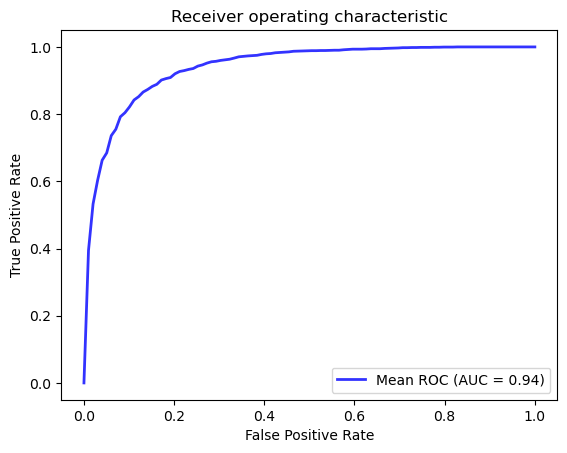

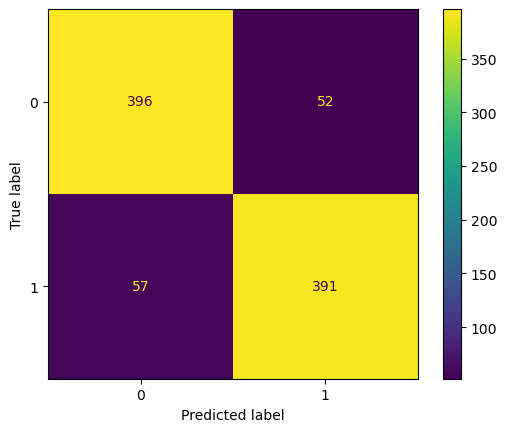

{'accuracy': 0.8668625079630514, 'recall': 0.8581609926821508, 'precision': 0.87331029388263, 'f1': 0.8656175455030851, 'roc_auc': 0.866863864142539}


In [16]:
# Create the pipeline
for mf in [4000,5500,7000,9000,]:
    logistic_pipeline = Pipeline([
        ('text_cleaning', TextCleanerTransformer()),
        ('tfidf', TfidfVectorizer(max_features=mf)),
        ('classifier', LogisticRegression(random_state= random_state))
    ])
    print(f"Eval for {mf} max_features in tfidf")
    log_reg_downsampled = fit_predict_eval(df_downsampled,logistic_pipeline)
    scores["log_reg_downsampled"] = log_reg_downsampled

    print(log_reg_downsampled)

... I call it a success. I lost accuracy, but I increased precision and recall.

Interesting fact is, that changing max_features in tfidf doesn't seem to affect the regression after downsampling. Probably the variaty of the words in not as big in this subset

## Random Forest Classifier

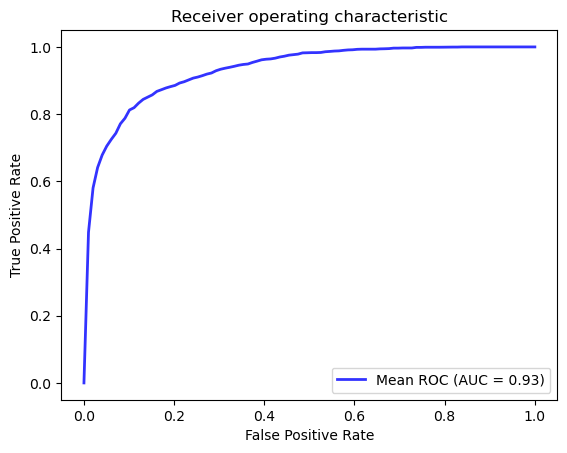

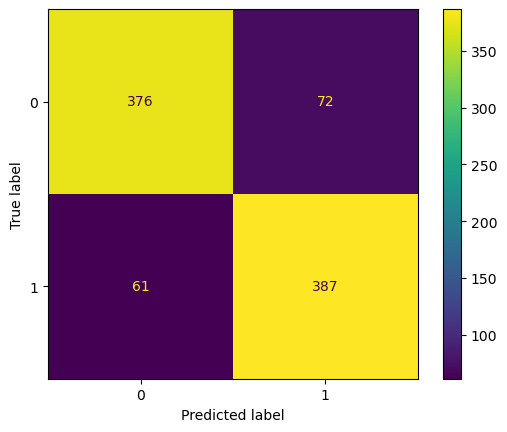

{'accuracy': 0.8539245401337793, 'recall': 0.8282900493159403, 'precision': 0.8739510890800354, 'f1': 0.8499496680189859, 'roc_auc': 0.8539298639834552}


In [17]:
from sklearn.ensemble import RandomForestClassifier
# Create the pipeline
forest_pipeline = Pipeline([
    ('text_cleaning', TextCleanerTransformer()),
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', RandomForestClassifier(random_state=random_state))
])
random_forest = fit_predict_eval(df_downsampled,forest_pipeline)
scores["random_forest_downsampled"] = random_forest
print(random_forest)

# Now let's try to optimize the params of RandomForestClassifier to maximazie the precision

Fitting 3 folds for each of 20 candidates, totalling 60 fits


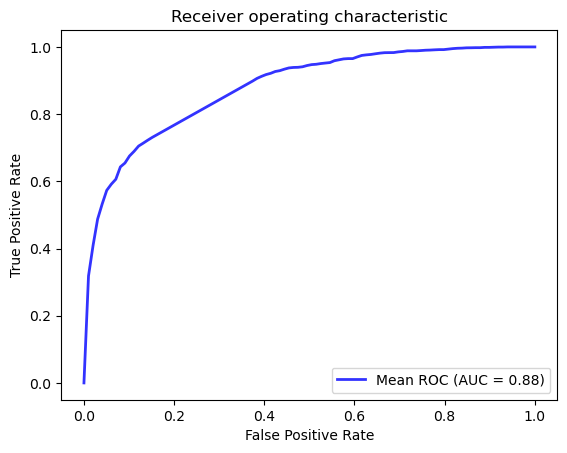

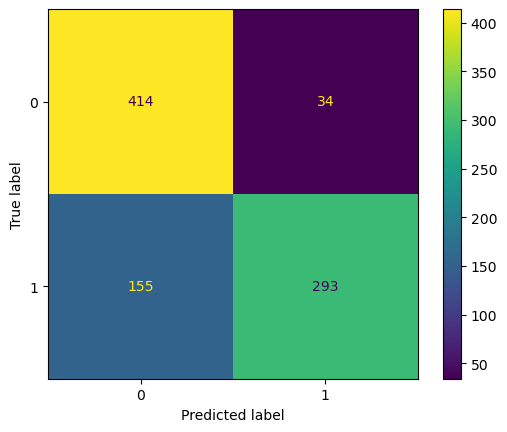

{'accuracy': 0.7825616638795987, 'recall': 0.6534531100859052, 'precision': 0.8824593318134675, 'f1': 0.7495493070632759, 'roc_auc': 0.7825808343938911}


In [21]:
# Trying with random search: 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# specify parameters and distributions to sample from
param_dist = {
    'tfidf__max_features': randint(1000, 7000),
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(3, 10),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 5)
}

rf_pipeline = Pipeline([
    ('text_cleaning', TextCleanerTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=random_state))
])

# run randomized search
n_iter_search = 20  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
random_search = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=n_iter_search, cv=3, scoring='precision', verbose=1, n_jobs=3)

# Split data
X = df_downsampled['tweet']
y = df_downsampled['label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

best_params = random_search.best_params_

# Create a new pipeline with the best parameters
best_rf_pipeline = Pipeline([
    ('text_cleaning', TextCleanerTransformer()),
    ('tfidf', TfidfVectorizer(max_features=best_params['tfidf__max_features'])),
    ('classifier', RandomForestClassifier(random_state=random_state,
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])
best_rf_scores = fit_predict_eval(df_downsampled, best_rf_pipeline)
scores["best_random_forest_downsampled"] = best_rf_scores
print(best_rf_scores)

# SVM

Fitting 3 folds for each of 20 candidates, totalling 60 fits


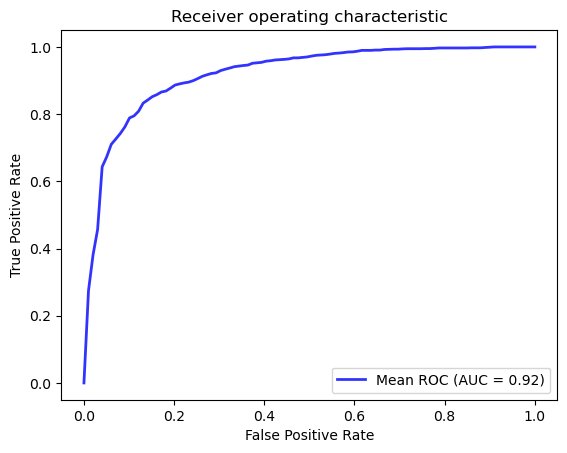

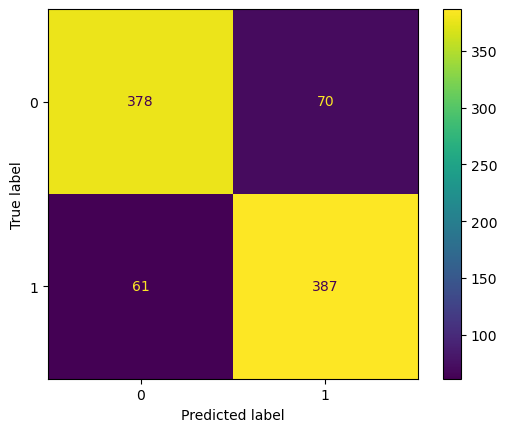

{'accuracy': 0.8508035216594999, 'recall': 0.8434477410117722, 'precision': 0.8562574541391375, 'f1': 0.8495349919342745, 'roc_auc': 0.8508023783009863}


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from scipy.stats import uniform, randint

# specify parameters and distributions to sample from
param_dist = {
    'tfidf__max_features': randint(1000, 7000),
    'classifier__C': uniform(0.1, 10),
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf']
}

svm_pipeline = Pipeline([
    ('text_cleaning', TextCleanerTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('classifier', svm.SVC(probability=True,random_state=random_state))
])

# run randomized search
n_iter_search = 20  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
random_search = RandomizedSearchCV(svm_pipeline, param_distributions=param_dist, n_iter=n_iter_search, cv=3, scoring='precision', verbose=1, n_jobs=3)

# Split data
X = df_downsampled['tweet']
y = df_downsampled['label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and create the best SVM pipeline
best_params = random_search.best_params_

best_svm_pipeline = Pipeline([
    ('text_cleaning', TextCleanerTransformer()),
    ('tfidf', TfidfVectorizer(max_features=best_params['tfidf__max_features'])),
    ('classifier', svm.SVC(random_state=random_state,probability=True,C=best_params['classifier__C'], gamma=best_params['classifier__gamma'], kernel=best_params['classifier__kernel']))
])

# Evaluate the best SVM model using fit_predict_eval
best_svm_scores = fit_predict_eval(df_downsampled, best_svm_pipeline)
scores["best_svm_downsampled"] = best_svm_scores

print(best_svm_scores)


## Summary

In [23]:
pd.DataFrame(scores)

,log_reg_no_downsampling,log_reg_downsampled,random_forest_downsampled,best_random_forest_downsampled,best_svm_downsampled
accuracy,0.935768,0.866863,0.853925,0.782562,0.850804
recall,0.793495,0.858161,0.828290,0.653453,0.843448
precision,0.528389,0.873310,0.873951,0.882459,0.856257
f1,0.634155,0.865618,0.849950,0.749549,0.849535
roc_auc,0.869998,0.866864,0.853930,0.782581,0.850802


#### Saving the best model



In [26]:
import joblib
# Save the entire pipeline
joblib.dump(best_rf_pipeline, 'saved_pipeline.pkl')


['saved_pipeline.pkl']

#### Summary:

In this notebook, I tackled the task of hate speech classification using various machine learning models. The goal was to build a classifier that could effectively identify hate speech in text data. I started by preprocessing the text data using techniques such as lowercasing, removing unwanted characters, removing stopwords, lemmatization, and stemming.

Next, I constructed different pipelines incorporating feature extraction through TF-IDF vectorization and implemented several classification models. The models I evaluated included logistic regression, random forest and support vector machines (SVM). For each model, I performed cross-validation, fine-tuned hyperparameters using GridSearchCV or RandomizedSearchCV, and evaluated their performance using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

After evaluating the models, my primary focus was on minimizing false positives. Precision, which measures the ability to correctly identify positive samples without misclassifying negatives, was the key metric for this objective. Based on precision scores, I determined that the best-performing models in terms of reducing false positives were the "best_random_forest_downsampled" and "log_reg_downsampled" models.

The "best_random_forest_downsampled" model achieved a precision of 0.882459, indicating a lower rate of false positives. The "log_reg_downsampled" model also exhibited strong performance with a precision of 0.873310.

Considering these findings, the "best_random_forest_downsampled" model, which combined random forest with downsampling, emerged as the top choice for minimizing false positives in hate speech classification.

It is worth noting that further analysis could explore additional aspects such as recall, F1-score, and ROC-AUC, and the interpretation of these metrics in the context of hate speech classification.

In conclusion, this study demonstrates the effectiveness of machine learning models in identifying hate speech, with the "best_random_forest_downsampled" model proving to be the most promising for minimizing false positives. Further research and development can build upon this work to improve hate speech detection and combat online toxicity effectively.